# setting up the environement

In [3]:
# !pip install pyarabic
# !pip install Arabic-Stopwords

# Loading libraries

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarabic.araby as araby
import arabicstopwords.arabicstopwords as stp
import re
import nltk
import pickle
import os
import gensim

from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from nltk.tokenize import word_tokenize
from collections import defaultdict
from math import log

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, PCA
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline

nltk.download('punkt')
nltk.download('stopwords')

SEED = 21

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading dataset

In [5]:
if os.path.exists("preprocessed_data.csv"):
    data = pd.read_csv("preprocessed_data.csv", header = 0, names = ["rating","review", "class"])
else:
    data = pd.read_csv("./datasets/LABR/reviews.tsv", sep = '\t', header=None, names = ["rating","review_id","user_id","book_id","review"])
data.head(20)

,rating,review,class
0,4,عزازيل صنع ذكر زيد بـ رخس استخدامه لحل فنة خدع...,pos
1,4,متع قرأ روي شك الش دند عزازيل هود ديب,pos
2,4,روي ارخ جوا خار ؤلف ارخ ندر نول روئ كتب بدق إت...,pos
3,1,قدر روي لسب درس قيم عبر ات فوت اون عهد درس حية...,neg
4,5,طلق اسم هيب تيم هيب فر قرت سيح بلد قتل تزج قتل...,pos
5,5,عزازيل اسم روي زيد صدر ؤخر دار جذب اسم بدي قرء...,pos
6,3,وعب بدي روي وصل نصف قرب قرأ وقع صدم طرق كتب رو...,pos
7,4,ادب روي,pos
8,4,قطف روي عزازيل كتب زيد خار شيئ سمء تخل شيء تصل...,pos
9,5,بدي بدي شوق لغي وقع كنز ادب أعد فور نهئ لعط تق...,pos


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60090 entries, 0 to 63256
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  60090 non-null  int64 
 1   review  59930 non-null  object
 2   class   60090 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.8+ MB


## Reviews distribution

Axes(0.125,0.11;0.775x0.77)


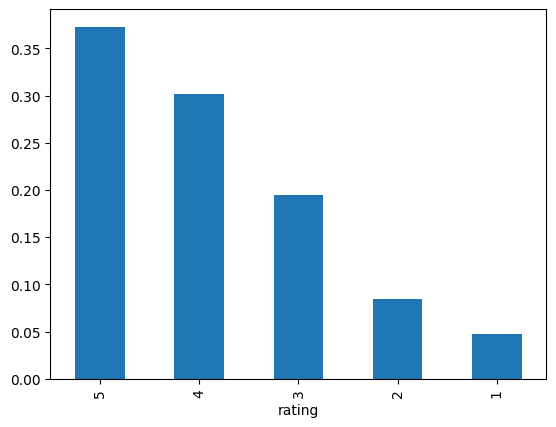

In [7]:
print(data['rating'].value_counts(normalize=True).plot(kind='bar'))

# Data preprocessing

## Rmoving unnecessary columns

In [8]:
if not os.path.exists("preprocessed_data.csv"):
    data = data.drop(['review_id','user_id','book_id'], axis=1)
    data.head()

## Removing duplicate entries

In [9]:
if not os.path.exists("preprocessed_data.csv"):
    count = data.duplicated().sum()
    print(f"{(count / data.shape[0]) * 100:.1f}% of the data are duplicats")

In [10]:
if not os.path.exists("preprocessed_data.csv"):
    data = data.drop_duplicates(subset='review', keep='first')

## Remove punctuations & special chars

In [11]:
if not os.path.exists("preprocessed_data.csv"):
    pattern = r'[^\w\s\u0600-\u06FF]+|_|ﷺ|۩|⓵|؟|؛|۞|ﷻ|،'
    data["review"] = data["review"].apply(lambda document: re.sub(pattern, ' ', document))

## Remove consecutive characters

In [12]:
if not os.path.exists("preprocessed_data.csv"):
    pattern = r'(.)\1+'
    data["review"] = data["review"].apply(lambda document: re.sub(pattern, r'\1', document))

## Remove numbers

In [13]:
if not os.path.exists("preprocessed_data.csv"):
    pattern = r'\d+'
    data["review"] = data["review"].apply(lambda document: re.sub(pattern, ' ', document))

## Remove extra whitespaces
In this step we get rid of extra whitespaces as well as new lines

In [14]:
if not os.path.exists("preprocessed_data.csv"):
    pattern = r'\s+|\n+'
    data["review"] = data["review"].apply(lambda document: re.sub(pattern, ' ', document))

## Removing arabic diactrics

In [15]:
if not os.path.exists("preprocessed_data.csv"):
    data["review"] = data["review"].apply(lambda document: araby.strip_tashkeel(document))

## Tokenization

In [16]:
if not os.path.exists("preprocessed_data.csv"):
    data["review"] = data["review"].apply(lambda document: word_tokenize(document))
    data.head()

## Removing long and short words

In [17]:
if not os.path.exists("preprocessed_data.csv"):
    data["review"] = data["review"].apply(lambda document: [word for word in document if len(word) < 9 or len(word) > 1])

## Stemming

In [18]:
if not os.path.exists("preprocessed_data.csv"):
    stemmer = ISRIStemmer()
    data.replace('', pd.NA, inplace=True)  # Replace empty strings with NA
    data.dropna(inplace=True)  # Drop rows with NA values
    data["review"] = data["review"].apply(lambda document: [stemmer.stem(word) for word in document])

## Removing stopwords

In [19]:
if not os.path.exists("preprocessed_data.csv"):
    arabic_stopwords = stopwords.words('arabic')
    arabic_stopwords.extend(stp.stopwords_list())
    with open("arabic_stopwords.txt", "r", encoding="UTF-8") as file:
        for word in file:
            arabic_stopwords.append(word.strip())
    arabic_stopwords = [stemmer.stem(stopword) for stopword in arabic_stopwords]
    arabic_stopwords = set(arabic_stopwords)

    data["review"] = data["review"].apply(lambda document: ' '.join([word for word in document if word not in arabic_stopwords]))

In [20]:
data.head(20)

,rating,review,class
0,4,عزازيل صنع ذكر زيد بـ رخس استخدامه لحل فنة خدع...,pos
1,4,متع قرأ روي شك الش دند عزازيل هود ديب,pos
2,4,روي ارخ جوا خار ؤلف ارخ ندر نول روئ كتب بدق إت...,pos
3,1,قدر روي لسب درس قيم عبر ات فوت اون عهد درس حية...,neg
4,5,طلق اسم هيب تيم هيب فر قرت سيح بلد قتل تزج قتل...,pos
5,5,عزازيل اسم روي زيد صدر ؤخر دار جذب اسم بدي قرء...,pos
6,3,وعب بدي روي وصل نصف قرب قرأ وقع صدم طرق كتب رو...,pos
7,4,ادب روي,pos
8,4,قطف روي عزازيل كتب زيد خار شيئ سمء تخل شيء تصل...,pos
9,5,بدي بدي شوق لغي وقع كنز ادب أعد فور نهئ لعط تق...,pos


## Add sentiment column

In [21]:
if not os.path.exists("preprocessed_data.csv"):
    sentiment = {
        1: "neg",
        2: "neg",
        3: "pos",
        4: "pos",
        5: "pos",
    }

    data["class"] = data["rating"].map(lambda rating: sentiment[rating])
    data.head()

## Saving the preprocessed data

In [22]:
if not os.path.exists("preprocessed_data.csv"):
    data.to_csv("preprocessed_data.csv")

# Text representation


## BoW (Bag-of-Words)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data["review"], data["class"], test_size = 0.2, random_state = SEED, stratify = data["class"])

vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(X_train.values.astype("U")).toarray().astype(np.float32)

X_test = vectorizer.transform(X_test.values.astype("U")).toarray().astype(np.float32)

X_train[0].shape

(34558,)

### Performance evaluation
#### Naive bayes

In [45]:
if os.path.exists("./models/BoW/NB.pkl"):
    # read model from disk
    model = open("./models/BoW/NB.pkl", 'rb').read()
    model: GaussianNB = pickle.loads(model)
else:
    model = GaussianNB()
    model.fit(X_train, y_train)
    # write model to disk
    mdl_bytes = pickle.dumps(model)
    open("./models/BoW/NB.pkl", 'wb').write(mdl_bytes)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="pos")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 38.07%
Precesion : 88.90%
Recall : 32.82%
F1 score : 47.94%


#### Logistic regression

In [46]:
if os.path.exists("./models/BoW/LR.pkl"):
    # read model from disk
    model = open("./models/BoW/LR.pkl", 'rb').read()
    model: LogisticRegression = pickle.loads(model)
else:
    model = LogisticRegression(random_state = SEED, max_iter = 200)
    model.fit(X_train, y_train)
    # write model to disk
    mdl_bytes = pickle.dumps(model)
    open("./models/BoW/LR.pkl", 'wb').write(mdl_bytes)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="pos")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 87.64%
Precesion : 89.92%
Recall : 96.60%
F1 score : 93.14%


#### SVM

In [50]:
if os.path.exists("./models/BoW/SVM_Pipeline.pkl"):
    # read pipeline from disk
    pipeline = open("./models/BoW/SVM_Pipeline.pkl", 'rb').read()
    pipeline = pickle.loads(pipeline)
else:
    steps = [
        ('pca', PCA(n_components = 80)),
        ('svm', SVC(random_state = SEED))
    ]
    pipeline = Pipeline(steps = steps)
    pipeline.fit(X_train, y_train)
    # write pipeline to disk
    pipeline_bytes = pickle.dumps(pipeline)
    open("./models/BoW/SVM_Pipeline.pkl", 'wb').write(pipeline_bytes)

y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 86.88%
Precesion : 86.88%
Recall : 86.88%
F1 score : 86.88%


#### Random forest

In [51]:
if os.path.exists("./models/BoW/RF.pkl"):
    # read model from disk
    model = open("./models/BoW/RF.pkl", 'rb').read()
    model = pickle.loads(model)
else:
    model = RandomForestClassifier(random_state = SEED)
    model.fit(X_train, y_train)
    # write model to disk
    mdl_bytes = pickle.dumps(model)
    open("./models/BoW/RF.pkl", 'wb').write(mdl_bytes)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 87.59%
Precesion : 87.59%
Recall : 87.59%
F1 score : 87.59%


## TF-IDF

In [53]:
X_train, X_test, y_train, y_test = train_test_split(data["review"], data["class"], test_size = 0.2, random_state = SEED, stratify= data["class"])

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train).astype(np.float32).toarray()
X_test = vectorizer.transform(X_test).astype(np.float32).toarray()

X_train[0].shape

(34558,)

### Performance evaluation
#### Naive bayes

In [55]:
if os.path.exists("./models/TFIDF/NB.pkl"):
    # read model from disk
    model = open("./models/TFIDF/NB.pkl", 'rb').read()
    model: GaussianNB = pickle.loads(model)
else:
    model = GaussianNB()
    model.fit(X_train, y_train)
    # write model to disk
    mdl_bytes = pickle.dumps(model)
    open("./models/TFIDF/NB.pkl", 'wb').write(mdl_bytes)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="pos")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 38.78%
Precesion : 88.94%
Recall : 33.73%
F1 score : 48.91%


#### Logistic regression

In [56]:
if os.path.exists("./models/TFIDF/LR.pkl"):
    # read model from disk
    model = open("./models/TFIDF/LR.pkl", 'rb').read()
    model: LogisticRegression = pickle.loads(model)
else:
    model = LogisticRegression(random_state = SEED, max_iter = 200)
    model.fit(X_train, y_train)
    # write model to disk
    mdl_bytes = pickle.dumps(model)
    open("./models/TFIDF/LR.pkl", 'wb').write(mdl_bytes)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="pos")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 88.59%
Precesion : 89.12%
Recall : 98.95%
F1 score : 93.78%


### SVM

In [57]:
if os.path.exists("./models/TFIDF/SVM_Pipeline.pkl"):
    # read pipeline from disk
    pipeline = open("./models/TFIDF/SVM_Pipeline.pkl", 'rb').read()
    pipeline = pickle.loads(pipeline)
else:
    steps = [
        ('pca', PCA(n_components = 80)),
        ('svm', SVC(random_state = SEED))
    ]
    pipeline = Pipeline(steps = steps)
    pipeline.fit(X_train, y_train)
    # write pipeline to disk
    pipeline_bytes = pickle.dumps(pipeline)
    open("./models/TFIDF/SVM_Pipeline.pkl", 'wb').write(pipeline_bytes)

y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 86.99%
Precesion : 86.99%
Recall : 86.99%
F1 score : 86.99%


### Random forest

In [58]:
if os.path.exists("./models/TFIDF/RF.pkl"):
    # read model from disk
    model = open("./models/TFIDF/RF.pkl", 'rb').read()
    model = pickle.loads(model)
else:
    model = RandomForestClassifier(random_state = SEED)
    model.fit(X_train, y_train)
    # write model to disk
    mdl_bytes = pickle.dumps(model)
    open("./models/TFIDF/RF.pkl", 'wb').write(mdl_bytes)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 87.59%
Precesion : 87.59%
Recall : 87.59%
F1 score : 87.59%


## LDA

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data["review"], data["class"], test_size = 0.2, random_state = SEED, stratify = data["class"])

vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(X_train.astype("U")).astype(np.float32).toarray()
X_test = vectorizer.transform(X_test.astype("U")).astype(np.float32).toarray()

lda = LatentDirichletAllocation(n_components = 170, random_state = SEED)
lda.fit(X_train)
X_train = lda.transform(X_train)
X_test = lda.transform(X_test)

### Performance evaluation

#### Naive bayes


In [27]:
if os.path.exists("./models/LDA/NB.pkl"):
    # read model from disk
    model = open("./models/LDA/NB.pkl", 'rb').read()
    model: GaussianNB = pickle.loads(model)
else:
    model = GaussianNB()
    model.fit(X_train, y_train)
    # write model to disk
    mdl_bytes = pickle.dumps(model)
    open("./models/LDA/NB.pkl", 'wb').write(mdl_bytes)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="pos")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 51.53%
Precesion : 91.78%
Recall : 48.56%
F1 score : 63.52%


#### Logistic regression

In [28]:
if os.path.exists("./models/LDA/LR.pkl"):
    # read model from disk
    model = open("./models/LDA/LR.pkl", 'rb').read()
    model: LogisticRegression = pickle.loads(model)
else:
    model = LogisticRegression(random_state = SEED, max_iter = 200)
    model.fit(X_train, y_train)
    # write model to disk
    mdl_bytes = pickle.dumps(model)
    open("./models/LDA/LR.pkl", 'wb').write(mdl_bytes)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="pos")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 86.89%
Precesion : 86.89%
Recall : 100.00%
F1 score : 92.98%


#### SVM

In [29]:
if os.path.exists("./models/LDA/SVM.pkl"):
    # read pipeline from disk
    model = open("./models/LDA/SVM.pkl", 'rb').read()
    model = pickle.loads(model)
else:
    model = SVC(random_state = SEED)
    model.fit(X_train, y_train)
    # write pipeline to disk
    model_bytes = pickle.dumps(model)
    open("./models/LDA/SVM.pkl", 'wb').write(model_bytes)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 86.88%
Precesion : 86.88%
Recall : 86.88%
F1 score : 86.88%


#### Random forest

In [30]:
if os.path.exists("./models/LDA/RF.pkl"):
    # read model from disk
    model = open("./models/LDA/RF.pkl", 'rb').read()
    model = pickle.loads(model)
else:
    model = RandomForestClassifier(random_state = SEED)
    model.fit(X_train, y_train)
    # write model to disk
    mdl_bytes = pickle.dumps(model)
    open("./models/LDA/RF.pkl", 'wb').write(mdl_bytes)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 86.61%
Precesion : 86.61%
Recall : 86.61%
F1 score : 86.61%


## LSA

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data["review"], data["class"], test_size = 0.2, random_state = SEED, stratify = data["class"])

vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(X_train.astype("U")).astype(np.float32).toarray()
X_test = vectorizer.transform(X_test.astype("U")).astype(np.float32).toarray()

lsa = TruncatedSVD(n_components = 200, random_state = SEED)
X_train = lsa.fit_transform(X_train)
X_test = lsa.transform(X_test)

### Performance evaluation

#### Naive bayes


In [36]:
if os.path.exists("./models/LSA/NB.pkl"):
    # read model from disk
    model = open("./models/LSA/NB.pkl", 'rb').read()
    model: GaussianNB = pickle.loads(model)
else:
    model = GaussianNB()
    model.fit(X_train, y_train)
    # write model to disk
    mdl_bytes = pickle.dumps(model)
    open("./models/LSA/NB.pkl", 'wb').write(mdl_bytes)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="pos")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 31.80%
Precesion : 88.83%
Recall : 24.60%
F1 score : 38.53%


#### Logistic regression

In [37]:
if os.path.exists("./models/LSA/LR.pkl"):
    # read model from disk
    model = open("./models/LSA/LR.pkl", 'rb').read()
    model: LogisticRegression = pickle.loads(model)
else:
    model = LogisticRegression(random_state = SEED, max_iter = 200)
    model.fit(X_train, y_train)
    # write model to disk
    mdl_bytes = pickle.dumps(model)
    open("./models/LSA/LR.pkl", 'wb').write(mdl_bytes)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="pos")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 86.89%
Precesion : 87.40%
Recall : 99.22%
F1 score : 92.94%


#### SVM

In [38]:
if os.path.exists("./models/LSA/SVM.pkl"):
    # read pipeline from disk
    model = open("./models/LSA/SVM.pkl", 'rb').read()
    model = pickle.loads(model)
else:
    model = SVC(random_state = SEED)
    model.fit(X_train, y_train)
    # write pipeline to disk
    model_bytes = pickle.dumps(model)
    open("./models/LSA/SVM.pkl", 'wb').write(model_bytes)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 86.88%
Precesion : 86.88%
Recall : 86.88%
F1 score : 86.88%


#### Random forest

In [39]:
if os.path.exists("./models/LSA/RF.pkl"):
    # read model from disk
    model = open("./models/LSA/RF.pkl", 'rb').read()
    model = pickle.loads(model)
else:
    model = RandomForestClassifier(random_state = SEED)
    model.fit(X_train, y_train)
    # write model to disk
    mdl_bytes = pickle.dumps(model)
    open("./models/LSA/RF.pkl", 'wb').write(mdl_bytes)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 87.00%
Precesion : 87.00%
Recall : 87.00%
F1 score : 87.00%


## Bag of Concepts
The BOC (Bag-of-Concepts) method has been proposed as a solution to the problem of large dimensions and sparsity that traditional methods such as TF-IDF and Bag of words suffer from.



### Word Embeddings
This is done using the AraVec model which is trained on arabic tweets

In [46]:
model = gensim.models.Word2Vec.load("./aravec/full_uni_cbow_100_twitter/full_uni_cbow_100_twitter.mdl")
word_vecs = {}
total, skipped = 0, 0
for tweet in data["review"]:
    for word in str(tweet).split(" "):
        total += 1
        try:
            word_vecs[word] = model.wv[word]
        except Exception:
            skipped += 1
print(f"total skipped : {skipped} ({(skipped / total) * 100 :.2f}%)")

total skipped : 266736 (13.83%)


### Clustering the words embeddings


In [47]:
NUM_CONCEPTS = 130
model = KMeans(n_clusters = NUM_CONCEPTS, random_state = SEED)
X = list(word_vecs.values())
model.fit(X)
concepts = model.predict(X)
print(len(X))

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


15686


### Concept Extraction

Now that we related words to concepts, we can create a document representataion, in which we express the degree of which a document contains a certain concept, and instead of taking only the freuqncies, we consider an approach similar to TF-IDF called, CF-IDF.

CF-IDF is defined using the following formula :

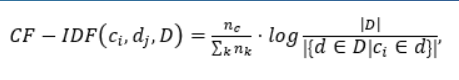

such that :

* |D| is the number of documents in the corpus
* n_c is the number of occurences of concept c in document d
* n_k is the total number of concepts in this document 

In [ ]:
NUM_DOCS = data.shape[0]

# construct a word to concept mapping
word_concept = {}
for index, word in enumerate(word_vecs.keys()):
    word_concept[word] = concepts[index]
print(word_concept)

In [51]:
# construct a concept to document count mapping
concept_docs = defaultdict(int)
for doc in data["review"]:
    doc_concepts = set()
    for word in str(doc).split(" "):
        try:
            doc_concepts.add(word_concept[word])
        except Exception:
            pass
    for concept in doc_concepts:
        concept_docs[concept] += 1
print(concept_docs)

defaultdict(<class 'int'>, {1: 18909, 3: 11672, 5: 8306, 7: 16195, 9: 7370, 10: 15658, 11: 14579, 15: 12753, 16: 13917, 17: 15336, 38: 5564, 40: 8688, 48: 10174, 49: 15507, 58: 12804, 71: 9865, 73: 8634, 74: 8468, 76: 27058, 82: 12626, 83: 16143, 85: 16295, 86: 47076, 87: 13739, 93: 7136, 95: 8272, 109: 23309, 110: 8096, 120: 36144, 122: 28068, 126: 11353, 35: 5978, 50: 2140, 57: 7564, 2: 5863, 101: 9239, 0: 4210, 6: 18377, 18: 4141, 21: 2537, 22: 14960, 28: 9552, 32: 8788, 33: 5909, 36: 6982, 37: 1790, 39: 10899, 41: 6695, 46: 7800, 52: 8874, 53: 15186, 54: 12219, 55: 11261, 56: 9791, 60: 16801, 61: 8218, 65: 15872, 66: 9880, 68: 5874, 80: 8609, 84: 9674, 88: 1432, 89: 8116, 94: 5963, 102: 4737, 113: 8564, 116: 7898, 119: 4297, 121: 4078, 124: 8063, 13: 5501, 62: 12981, 63: 4888, 14: 8412, 23: 644, 24: 11227, 29: 1835, 31: 5260, 59: 1751, 69: 1609, 72: 2334, 91: 987, 98: 3313, 100: 5863, 103: 6709, 123: 4464, 27: 3112, 99: 2875, 112: 2153, 34: 1174, 78: 1128, 114: 46, 125: 721, 8: 156

In [56]:
def cf_idf(document: str):
    """ Returns the CD-IDF representataion of a document """
    res = [0 for _ in range(NUM_CONCEPTS)]
    concepts_counts = defaultdict(int)
    for word in str(document).split(" "):
        try:
            concepts_counts[word_concept[word]] += 1
        except:
            pass
    n_k = sum(concepts_counts.values()) # number of concepts present in the document (duplicates are considered!)
    for concept in range(NUM_CONCEPTS):
        if concepts_counts[concept] != 0:
            res[concept] = (concepts_counts[concept] / n_k) * log(NUM_DOCS / (1 + concept_docs[concept]))
    return res

In [57]:
X = [cf_idf(tweet) for tweet in data["review"]]
y = data["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = SEED, stratify = y)

### Performance Evaluation

#### Naive bayes

In [59]:
if os.path.exists("./models/BOC/NB.pkl"):
    # read model from disk
    model = open("./models/BOC/NB.pkl", 'rb').read()
    model: GaussianNB = pickle.loads(model)
else:
    model = GaussianNB()
    model.fit(X_train, y_train)
    # write model to disk
    mdl_bytes = pickle.dumps(model)
    open("./models/BOC/NB.pkl", 'wb').write(mdl_bytes)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="pos")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 16.61%
Precesion : 91.67%
Recall : 4.42%
F1 score : 8.44%


#### Logistic regression

In [60]:
if os.path.exists("./models/BOC/LR.pkl"):
    # read model from disk
    model = open("./models/BOC/LR.pkl", 'rb').read()
    model: LogisticRegression = pickle.loads(model)
else:
    model = LogisticRegression(random_state = SEED, max_iter = 200)
    model.fit(X_train, y_train)
    # write model to disk
    mdl_bytes = pickle.dumps(model)
    open("./models/BOC/LR.pkl", 'wb').write(mdl_bytes)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label="pos")

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 86.84%
Precesion : 86.98%
Recall : 99.80%
F1 score : 92.95%


#### SVM

In [61]:
if os.path.exists("./models/BOC/SVM.pkl"):
    # read pipeline from disk
    model = open("./models/BOC/SVM.pkl", 'rb').read()
    model = pickle.loads(model)
else:
    model = SVC(random_state = SEED)
    model.fit(X_train, y_train)
    # write pipeline to disk
    model_bytes = pickle.dumps(model)
    open("./models/BOC/SVM.pkl", 'wb').write(model_bytes)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 86.84%
Precesion : 86.84%
Recall : 86.84%
F1 score : 86.84%


#### Random forest

In [63]:
if os.path.exists("./models/BOC/RF.pkl"):
    # read model from disk
    model = open("./models/BOC/RF.pkl", 'rb').read()
    model = pickle.loads(model)
else:
    model = RandomForestClassifier(random_state = SEED)
    model.fit(X_train, y_train)
    # write model to disk
    mdl_bytes = pickle.dumps(model)
    open("./models/BOC/RF.pkl", 'wb').write(mdl_bytes)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precesion : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 score : {f1_score * 100:.2f}%")

Accuracy: 86.69%
Precesion : 86.69%
Recall : 86.69%
F1 score : 86.69%
